<a href="https://colab.research.google.com/github/Ilvecho/Project_5/blob/main/Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from datetime import timedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Import and load data

In [2]:
files.upload()
pass

Saving 2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv to 2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv to 2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv to 2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv to 2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv to 2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv to 2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv to 2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv
Saving 2020Q1Q2Q

In [6]:
tmp_data = pd.read_csv('2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv')[:-1]
test = tmp_data['Change %'].apply(lambda x: float(x.strip('%')))
test

0     -1.10
1      1.29
2      3.85
3     -2.09
4     -3.13
       ... 
295   -2.31
296   -1.86
297   -0.61
298    1.14
299   -2.92
Name: Change %, Length: 300, dtype: float64

In [7]:
file_list = os.listdir('/content/')
price = {}
change = {}

for filename in file_list:
  if filename.startswith('2020Q1'):
    country = filename.split(' - ')[1].strip()
    tmp_data = pd.read_csv(filename)[:-1]
    tmp_data['Date'] = pd.to_datetime(tmp_data['Date'])
    tmp_data.set_index('Date', inplace=True)

    try:
      price[country] = tmp_data['Price'].astype(float).sort_index()
      change[country] = tmp_data['Change %'].apply(lambda x: float(x.strip('%'))).sort_index()
    except:
      tmp_data['Price'] = tmp_data['Price'].apply(lambda x: x.replace(',', ''))
      price[country] = tmp_data['Price'].astype(float).sort_index()
      change[country] = tmp_data['Change %'].apply(lambda x: float(x.strip('%'))).sort_index()

In [ ]:
for key in price.keys():
  print('\n\n###########\n')
  print(price[key].info())

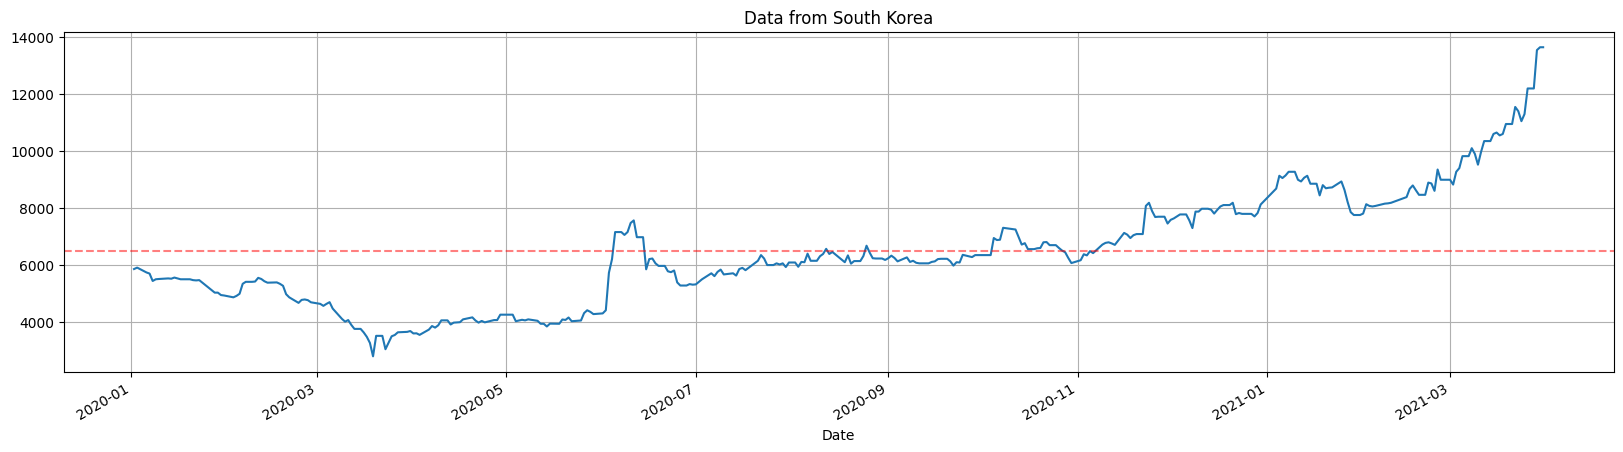

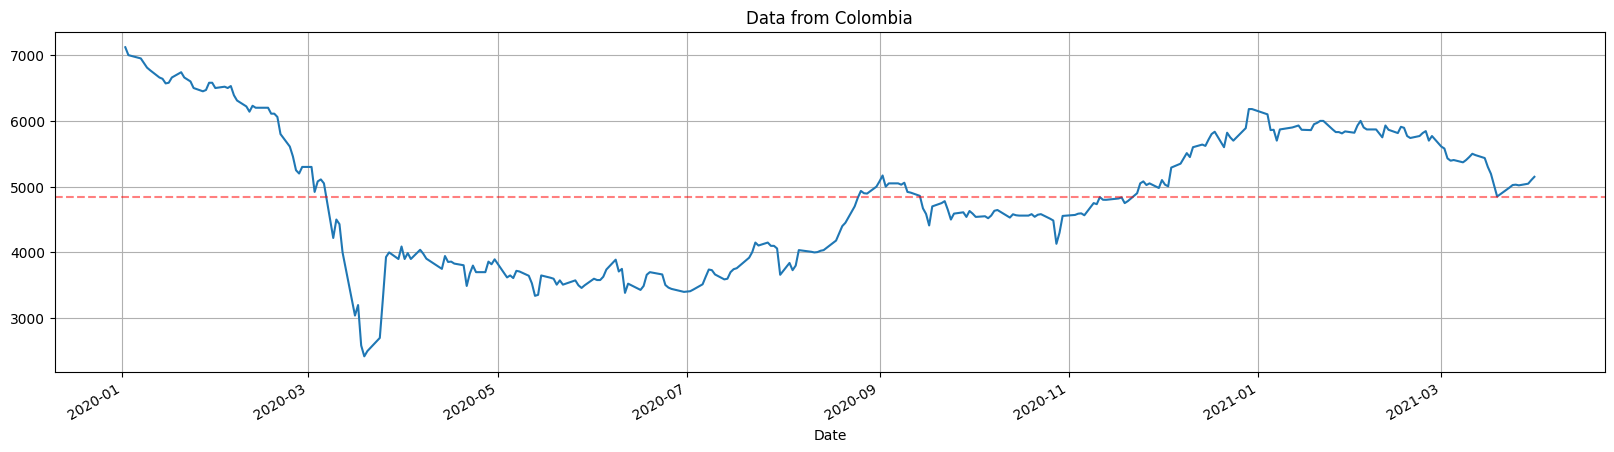

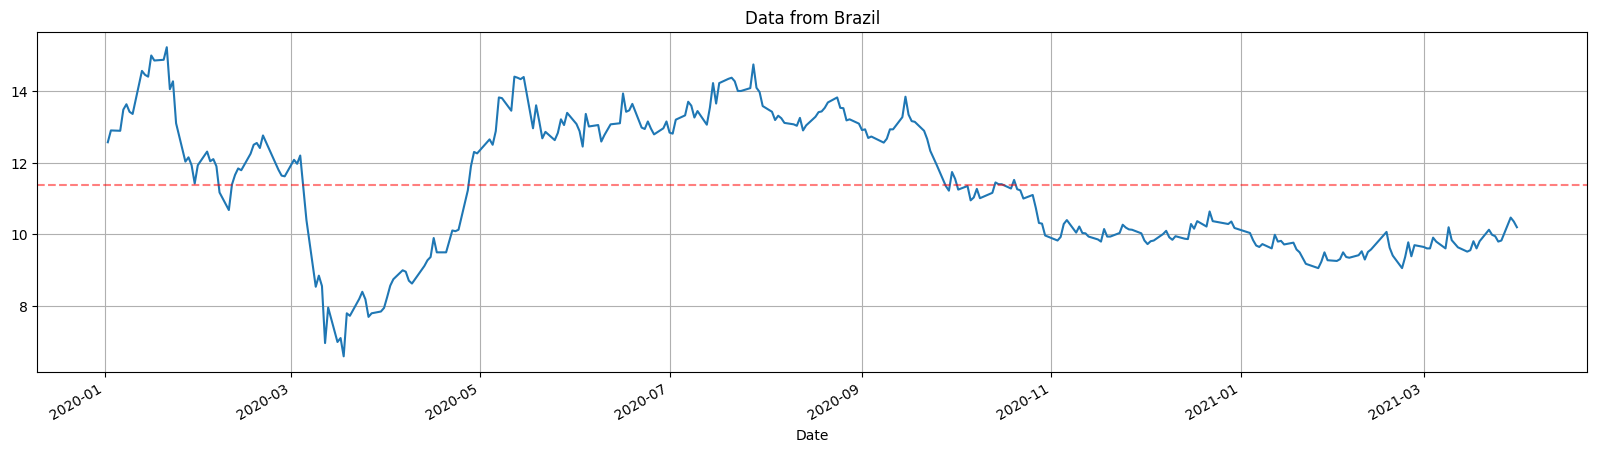

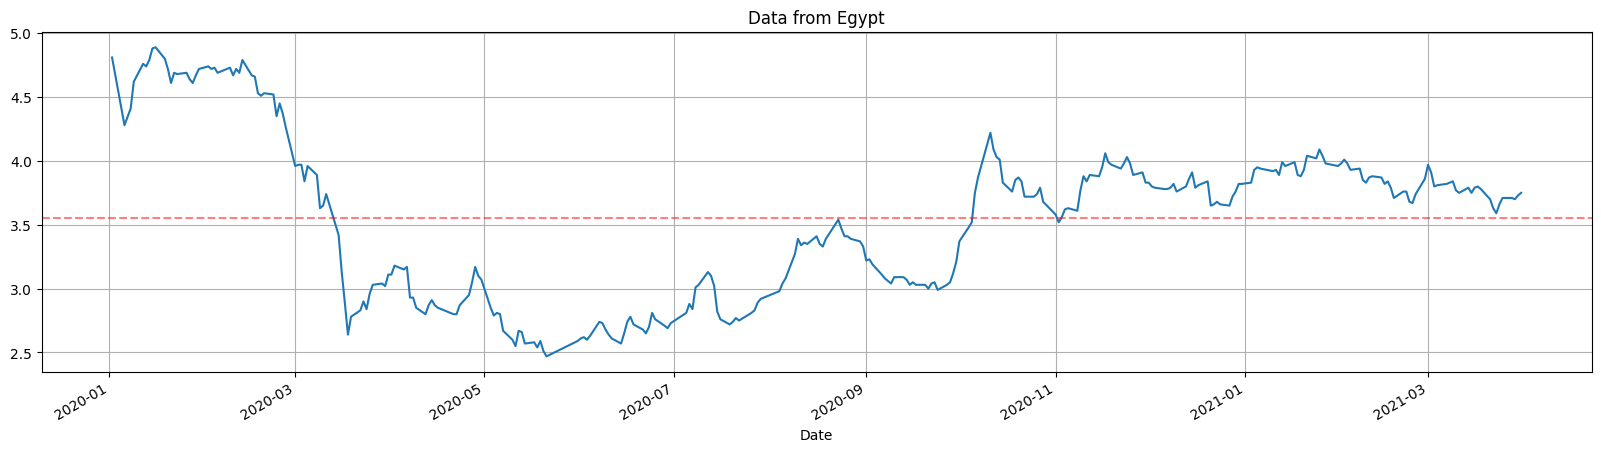

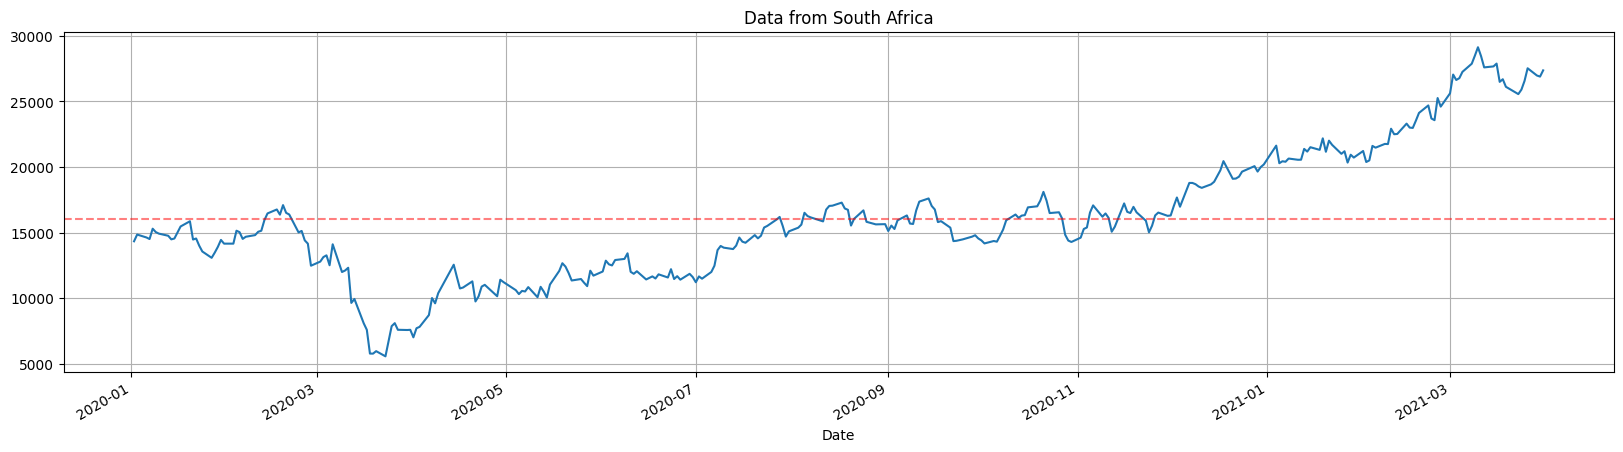

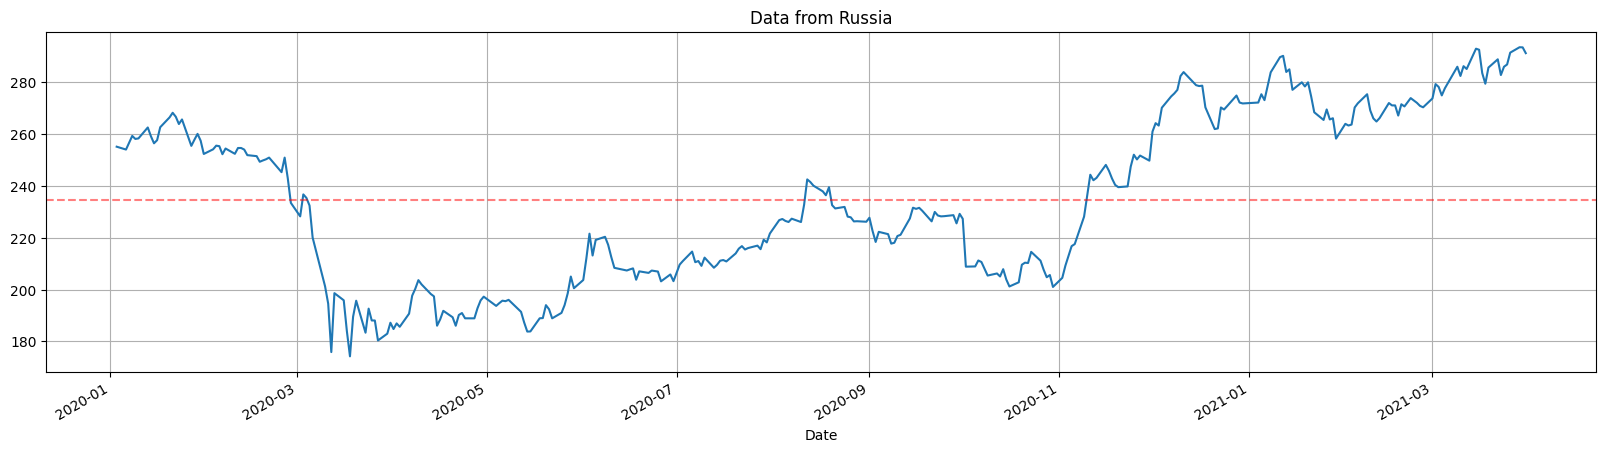

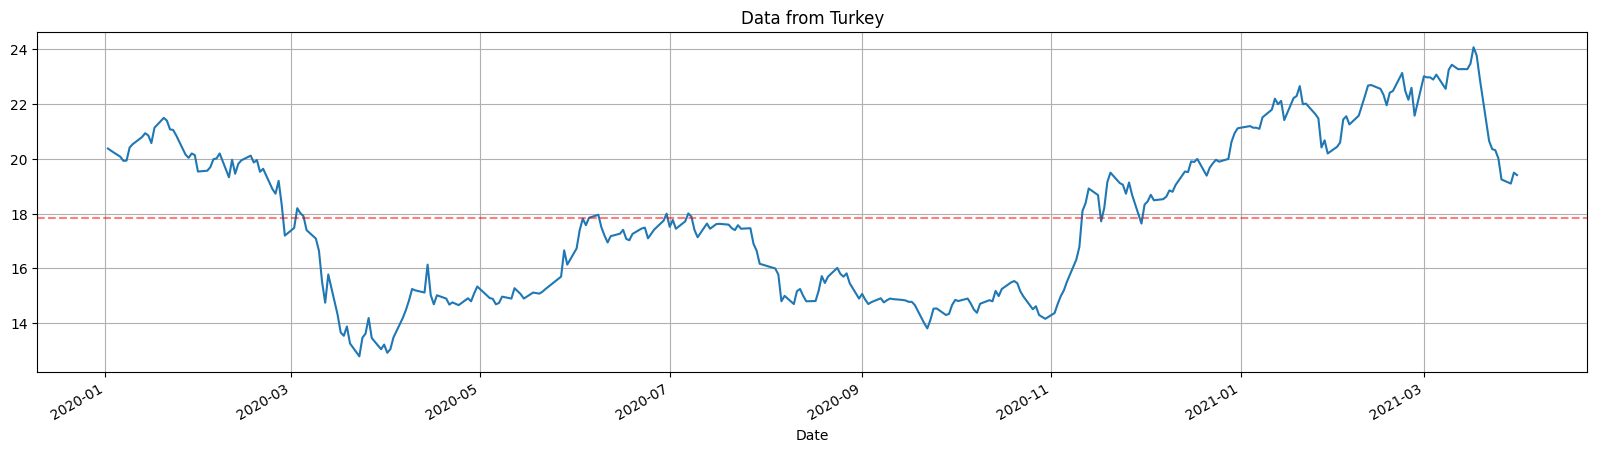

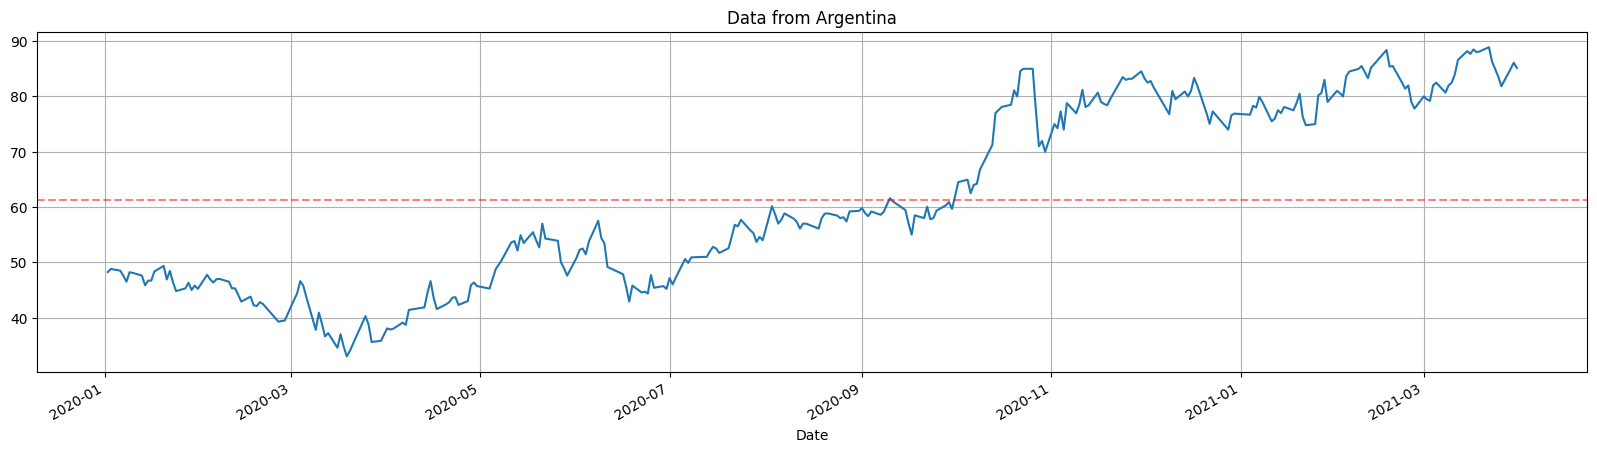

In [8]:
for key in price.keys():
  price[key].plot(figsize=(20,5), title=f'Data from {key}', grid='on')
  plt.axhline(y=price[key].mean(), color='red',  alpha=0.5, linestyle='--')
  plt.show()

We can clearly see that the Price time series are **not stationary** (we will robustly test this statement, but also the visual inspection is enough)

Let's analyse the **change %** instead and see how it behaves

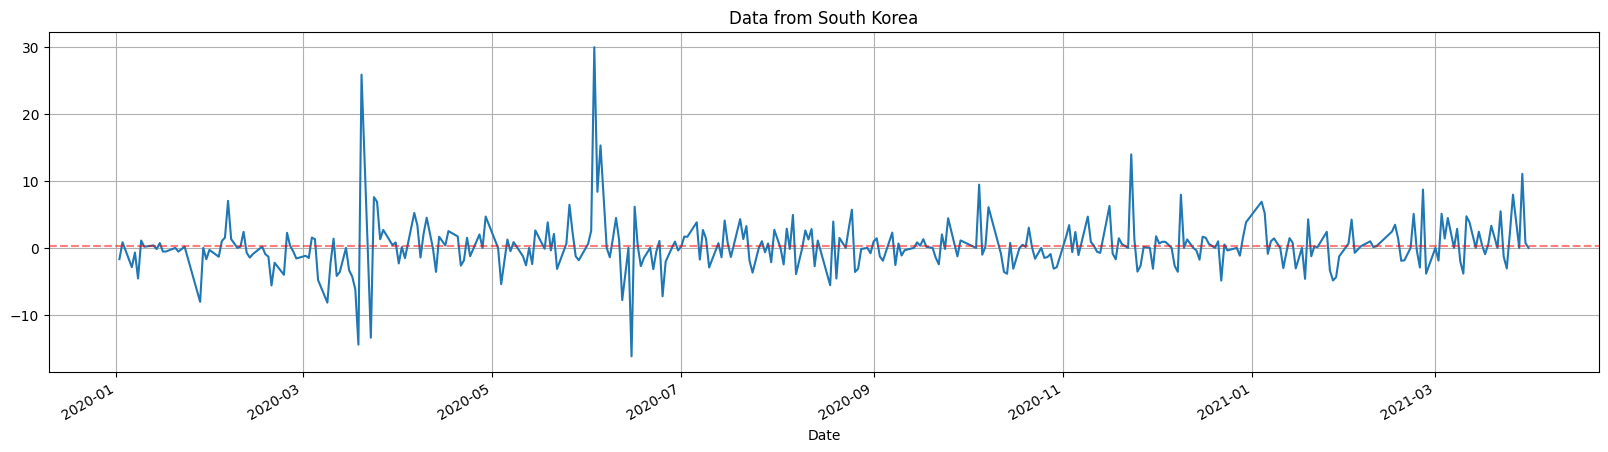

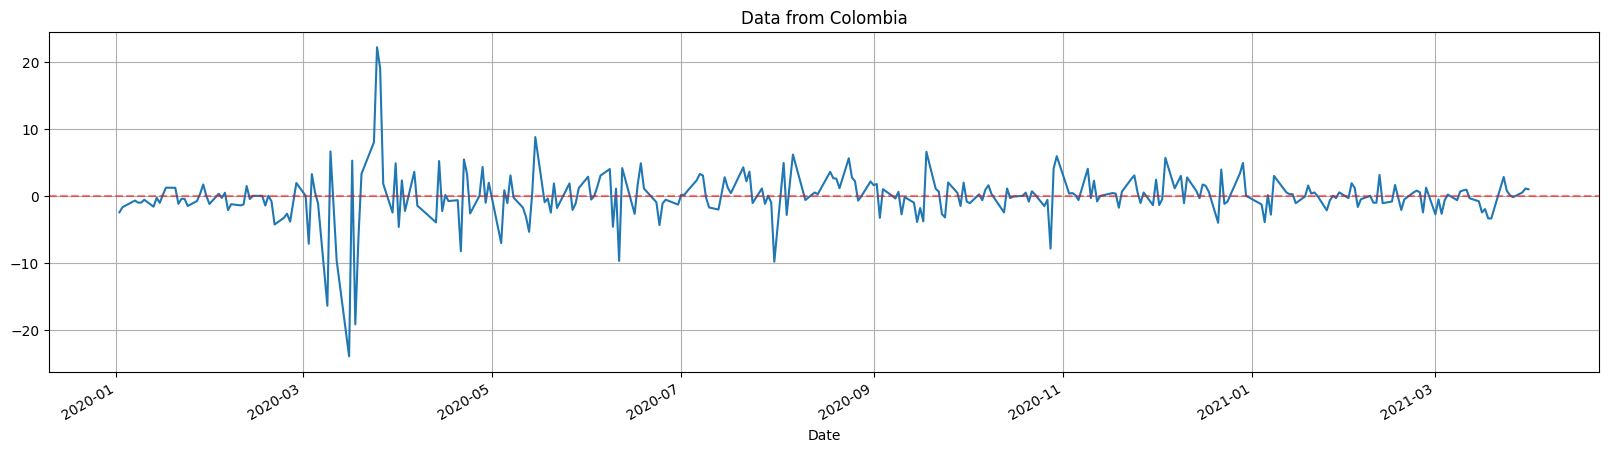

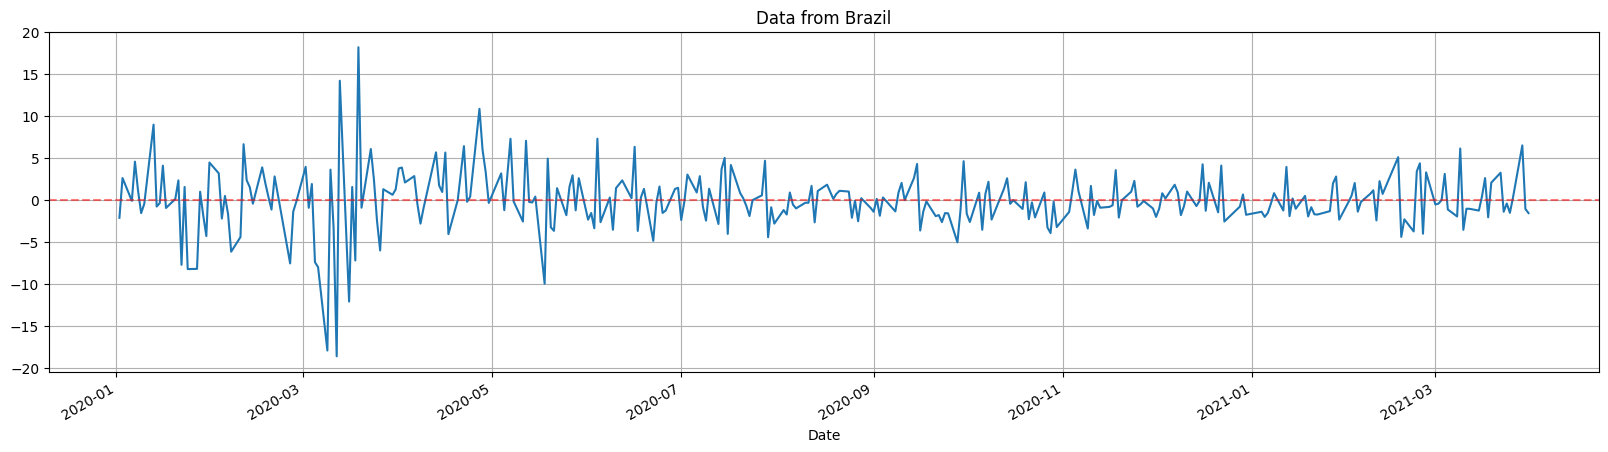

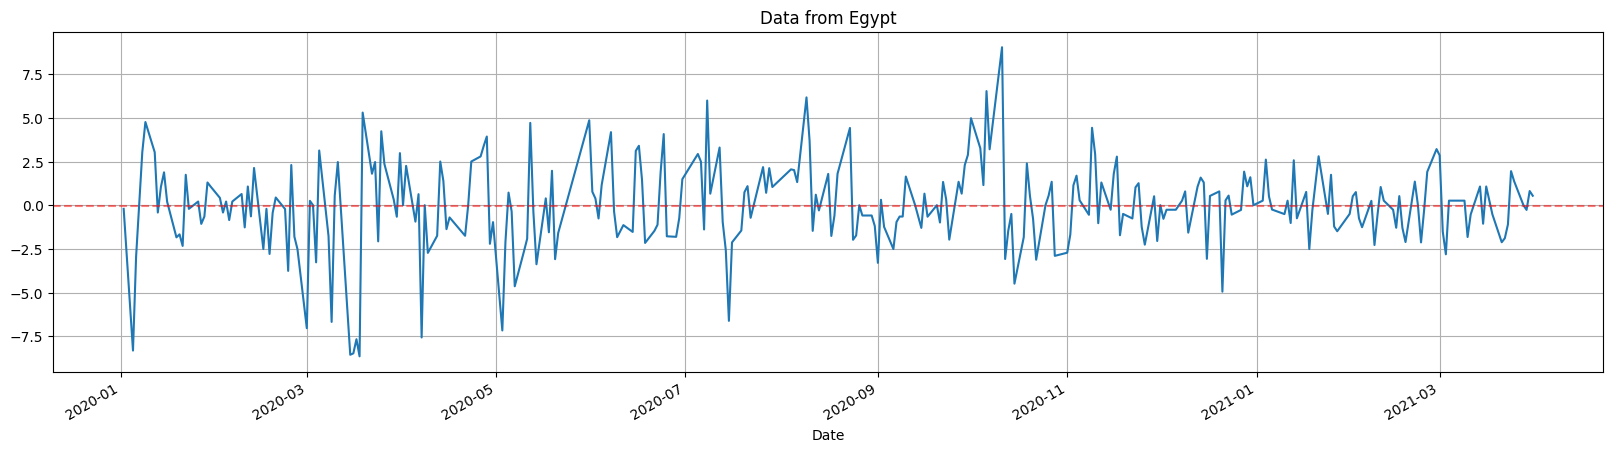

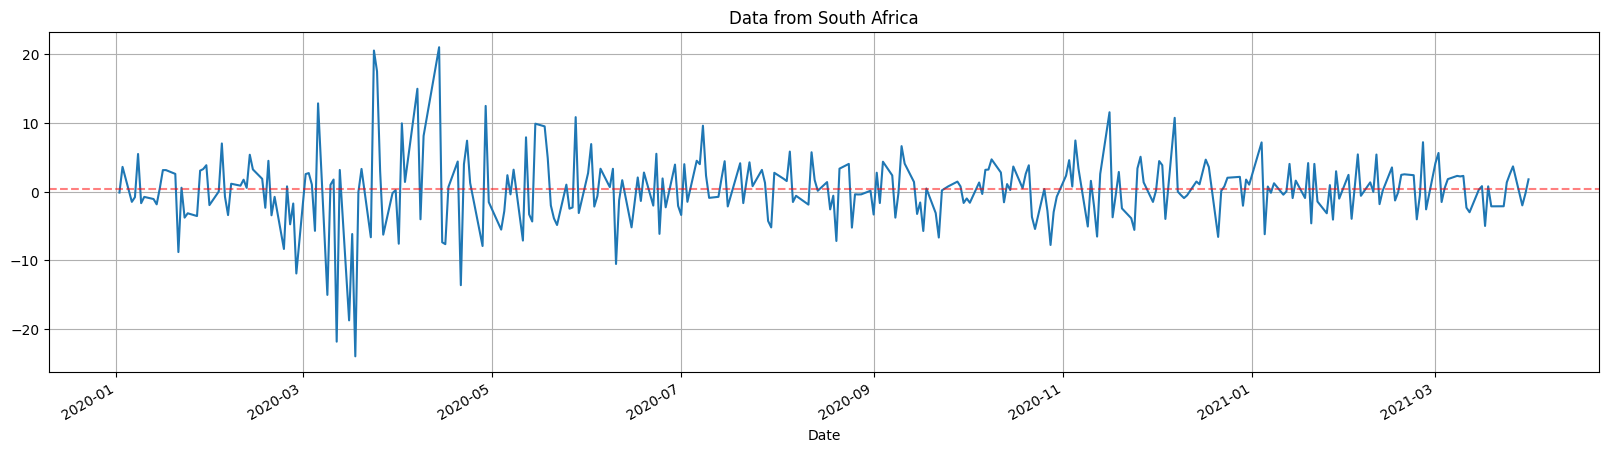

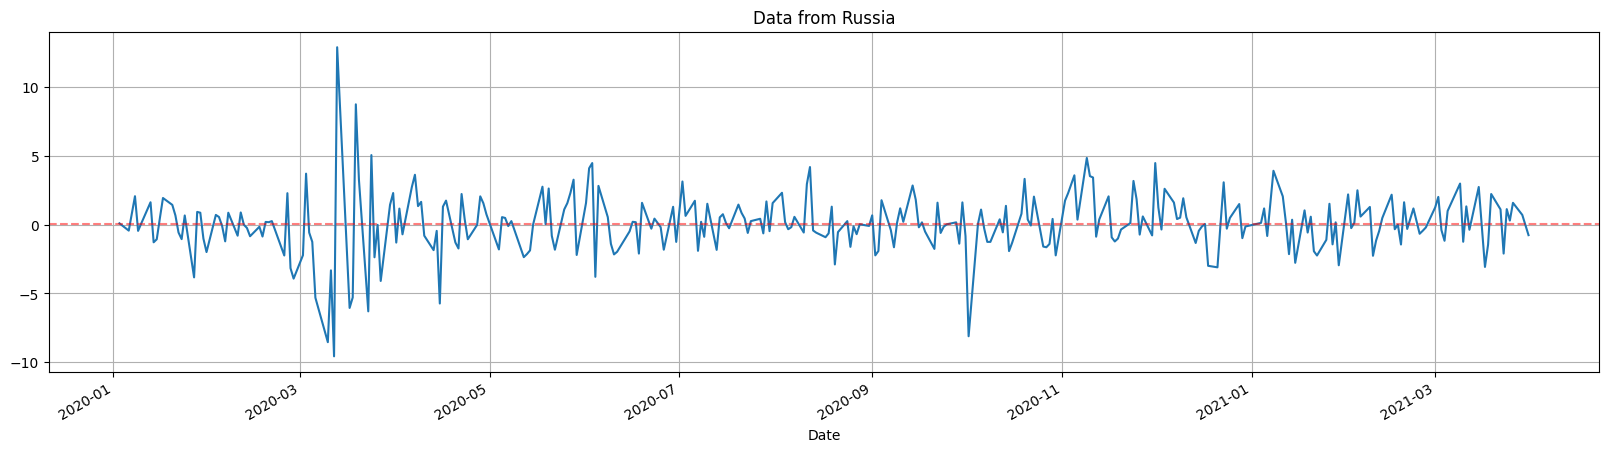

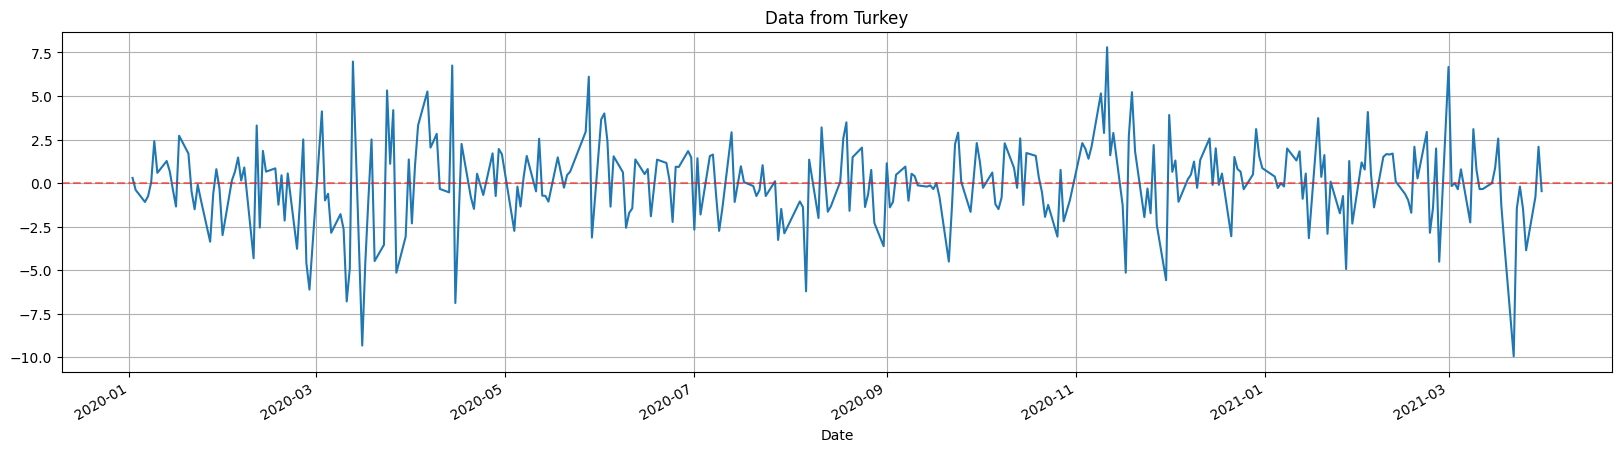

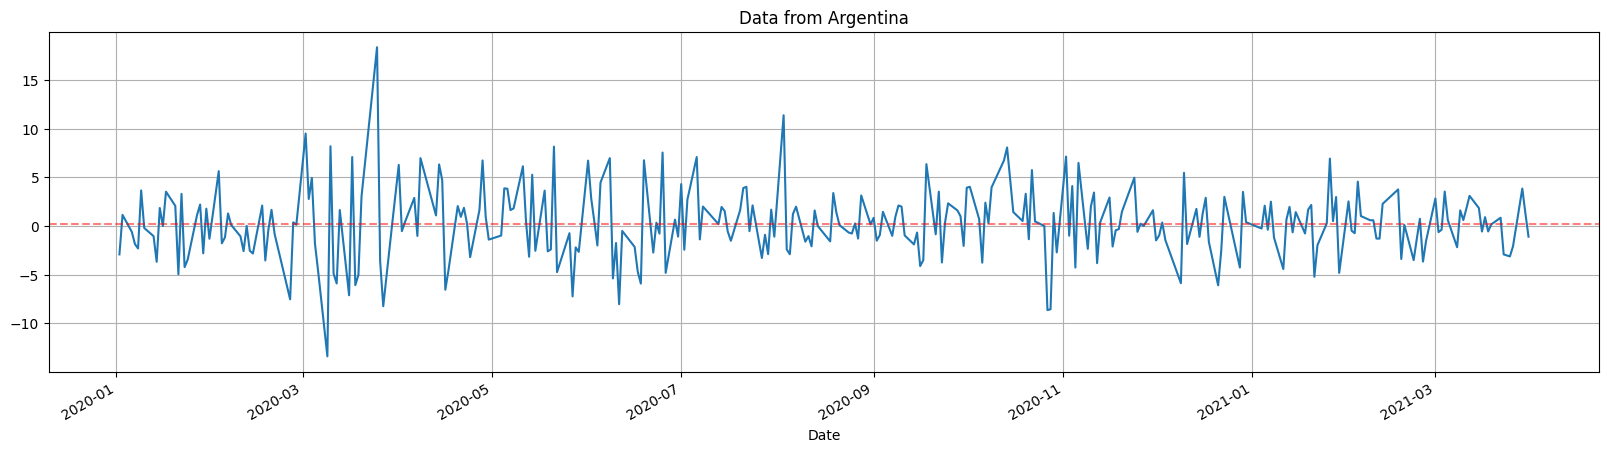

In [9]:
for key in change.keys():
  change[key].plot(figsize=(20,5), title=f'Data from {key}', grid='on')
  plt.axhline(y=change[key].mean(), color='red',  alpha=0.5, linestyle='--')
  plt.show()

These series look **much better**.
Furthermore, the range of values covered by the different series is much similar compared to the prices.

# EDA - stationarity

We verify the stationarity of the time series using the **Augmented Dickey-Fuller** test

In [3]:
exp_price = price['Argentina']
exp_price = exp_price.asfreq('b')
exp_price = exp_price.fillna(method='ffill')

results = adfuller(exp_price)
print('The p-value of the series is: ', results[1])

The p-value of the series is:  0.8756756136964812


Since the p-value of the series is **greater than 0.5**, then the series is **not stationary**.

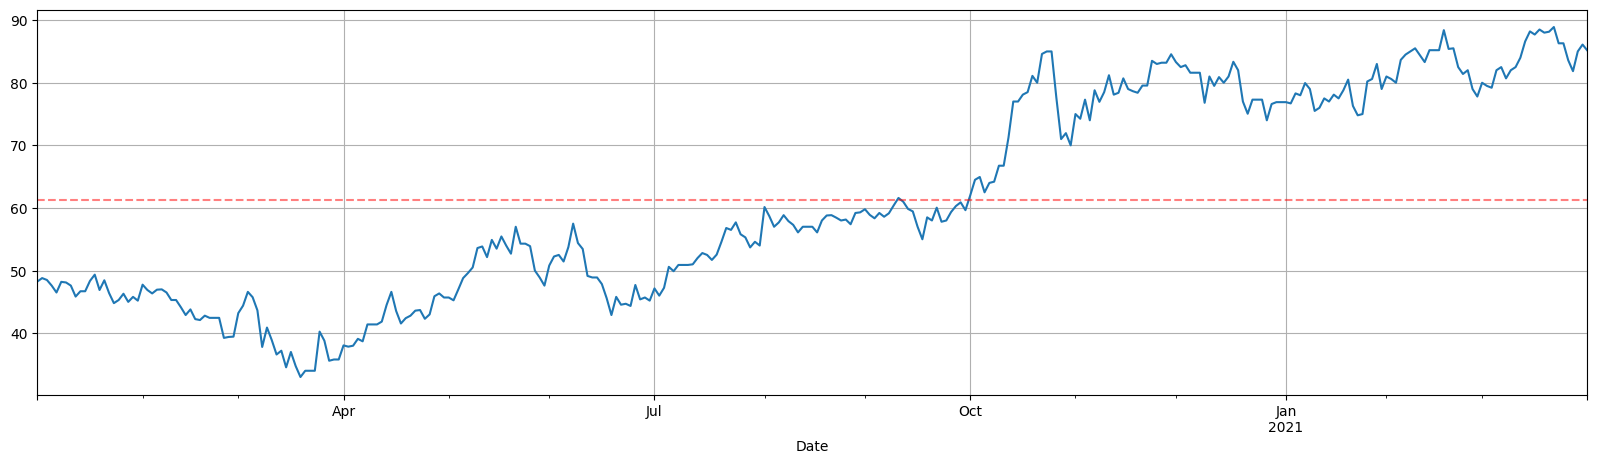

In [30]:
exp_price.plot(figsize=(20,5), grid='on')
plt.axhline(y=exp_price.mean(), color='red',  alpha=0.5, linestyle='--')
plt.show()

Let's now perform the same analysis on the change:

The p-value of the series is:  2.3476184551068446e-30


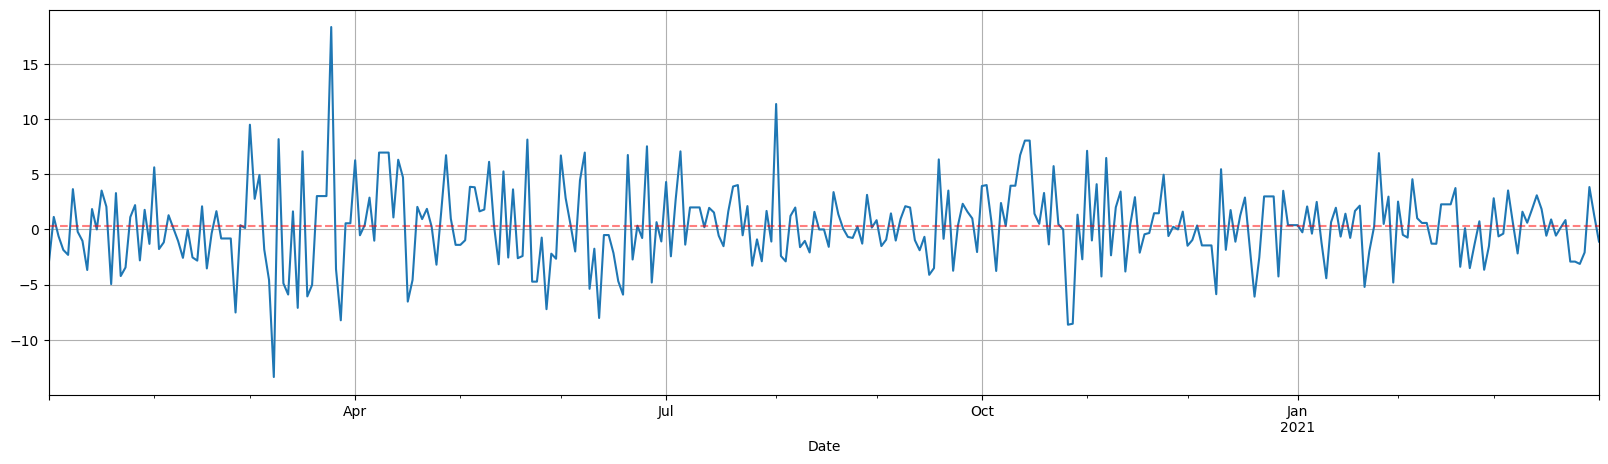

In [13]:
exp_change = change['Argentina']
exp_change = exp_change.asfreq('b')
exp_change = exp_change.fillna(method='ffill')

results = adfuller(exp_change)
print('The p-value of the series is: ', results[1])

exp_change.plot(figsize=(20,5), grid='on')
plt.axhline(y=exp_change.mean(), color='red',  alpha=0.5, linestyle='--')
plt.show()

The Augmented Dickey-Fuller test confirms the visual inspection conclusions:

the change series is **stationary**. Hence, from now on we will use these series.

Further looking at the change graph, we notice that the **volatility changes over time**.

This is an indication that we should use a **GARCH** model to predict the series.

# EDA - autocorrelation

let's compute the autocorrelation of the change series

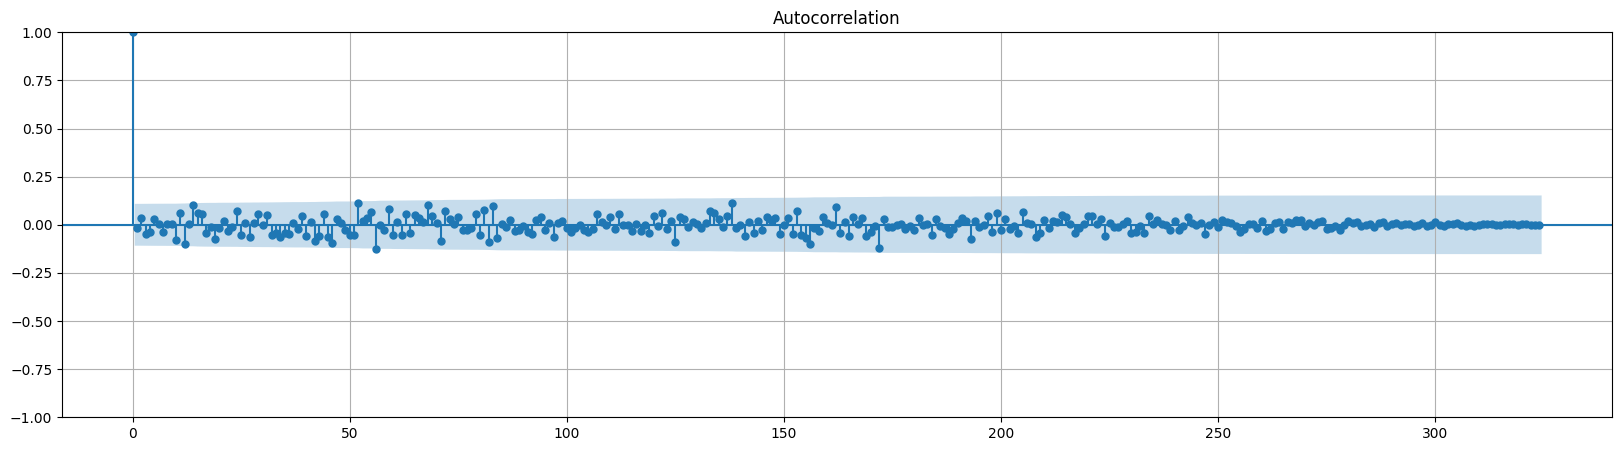

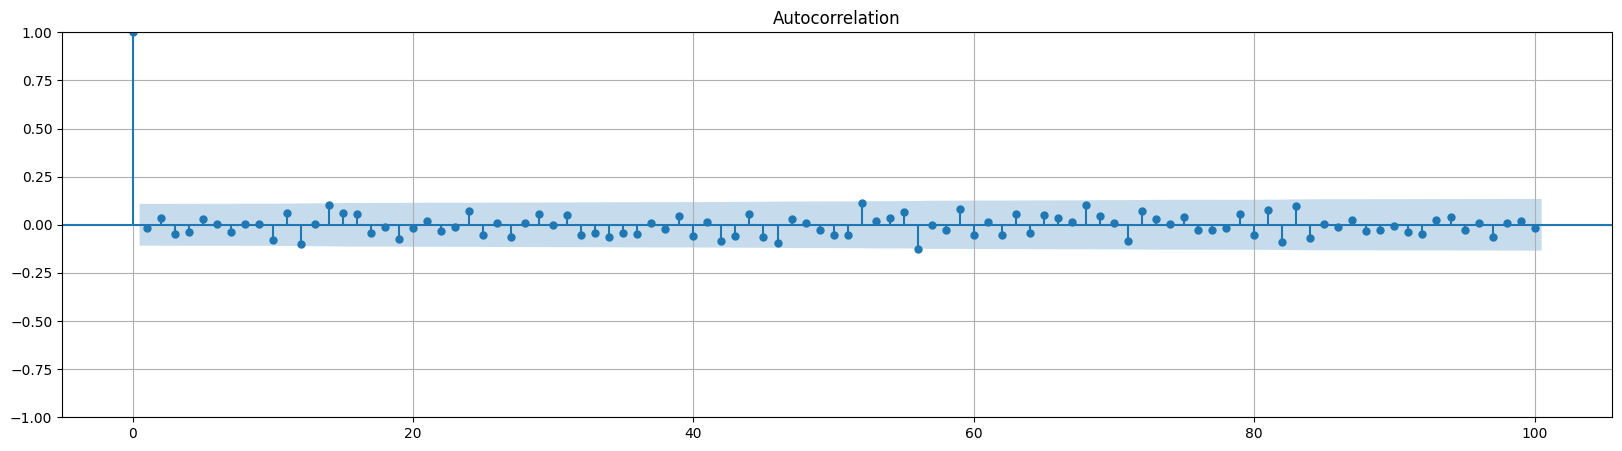

In [14]:
plt.figure(figsize=(20, 5))
sm.graphics.tsa.plot_acf(exp_change, lags=len(exp_change)-1, ax=plt.gca())
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 5))
sm.graphics.tsa.plot_acf(exp_change, lags=100, ax=plt.gca())
plt.grid(True)
plt.show()

The Auto Correlation Function shows that just few lags are somehow statistically relevant:

12, 14, 52, 56

Let's now compute the **partial** autocorrelation of the diff series

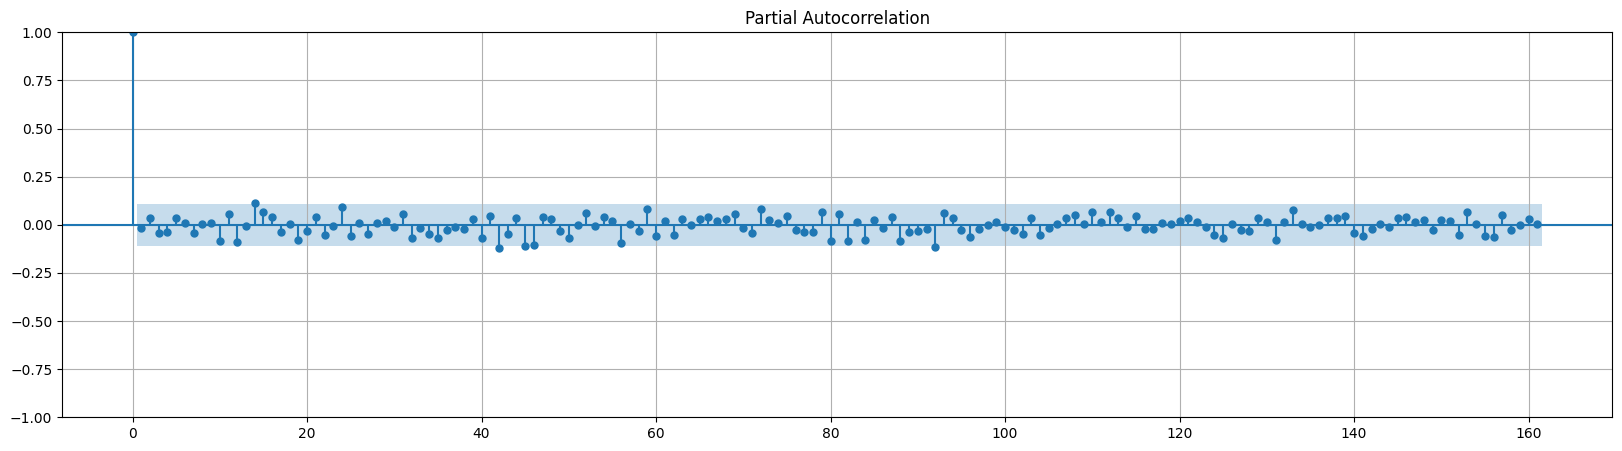

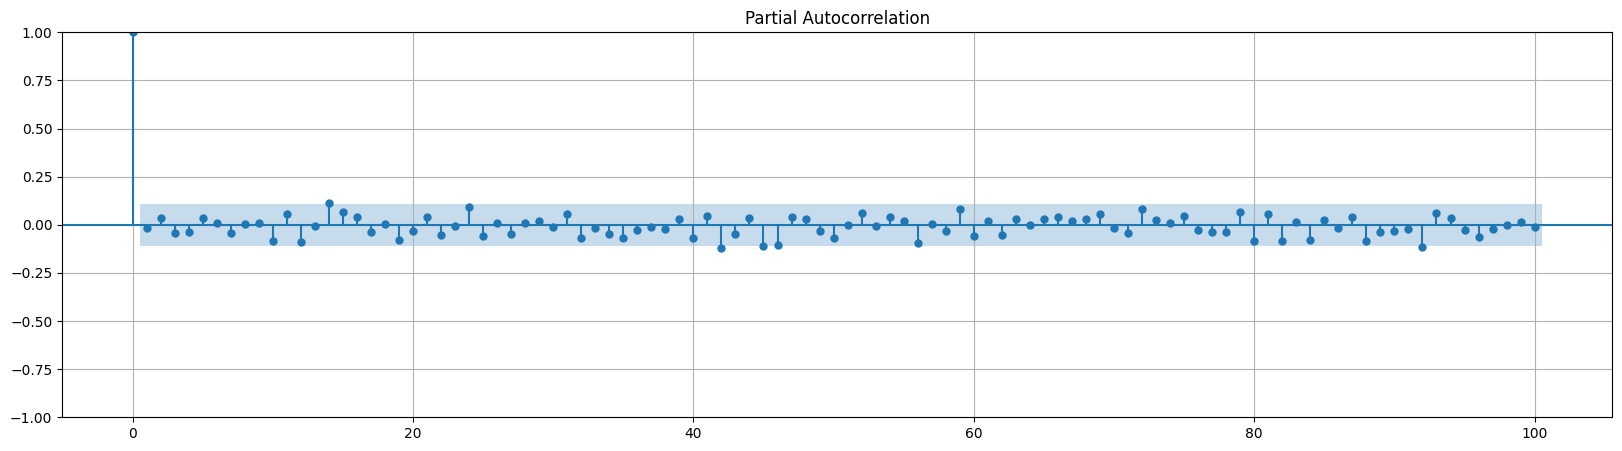

In [15]:
plt.figure(figsize=(20, 5))
sm.graphics.tsa.plot_pacf(exp_change, lags=len(exp_change)/2 -1, ax=plt.gca())
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 5))
sm.graphics.tsa.plot_pacf(exp_change, lags=100, ax=plt.gca())
plt.grid(True)
plt.show()

Also the PACF shows very little correlation.

The lags somehow statistically relevant are:
12, 14, 24, 42, 45, 46 and 92

what if we look at a different series?

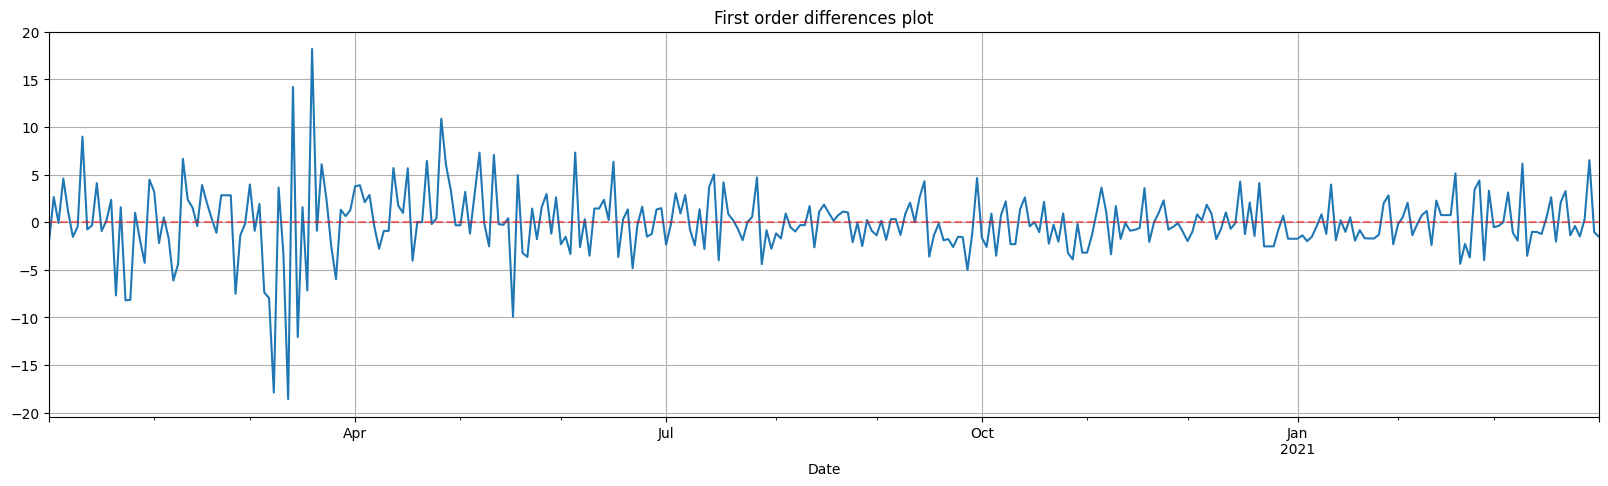

The p-value of the series is:  1.2389232057027393e-11


In [17]:
exp_change = change['Brazil']
exp_change = exp_change.asfreq('b')
exp_change = exp_change.fillna(method='ffill')

exp_change.plot(figsize=(20,5), title=f'First order differences plot', grid='on')
plt.axhline(y=exp_change.mean(), color='red',  alpha=0.5, linestyle='--')
plt.show()

results = adfuller(exp_change)
print('The p-value of the series is: ', results[1])

Once again, the change time series looks stationary, and the DF test confirms it

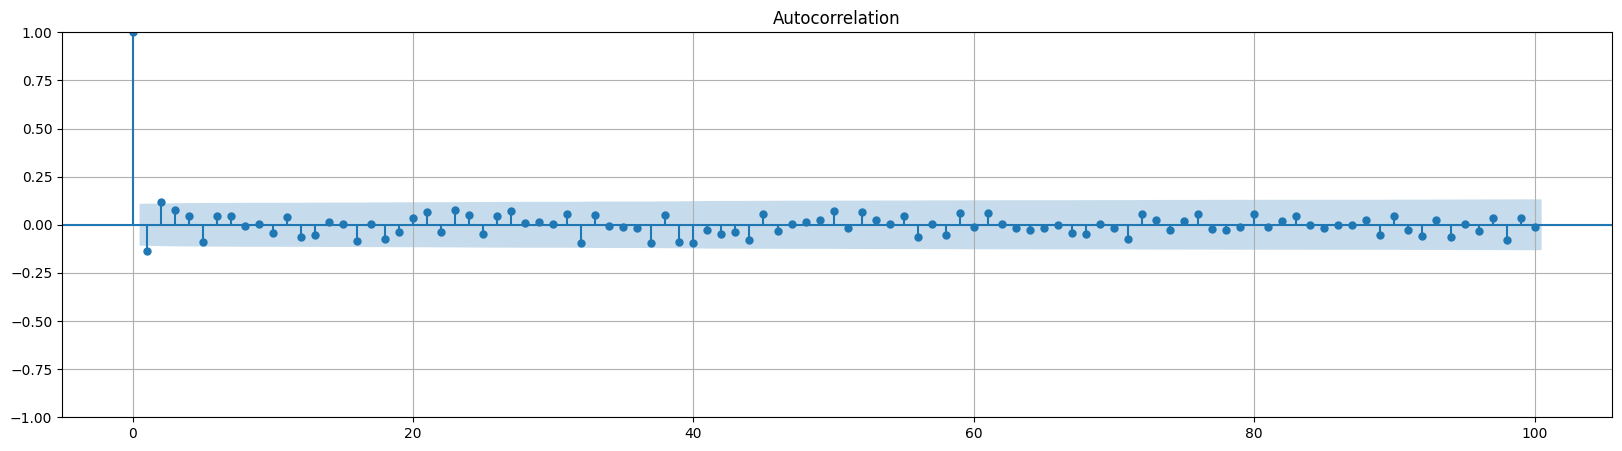

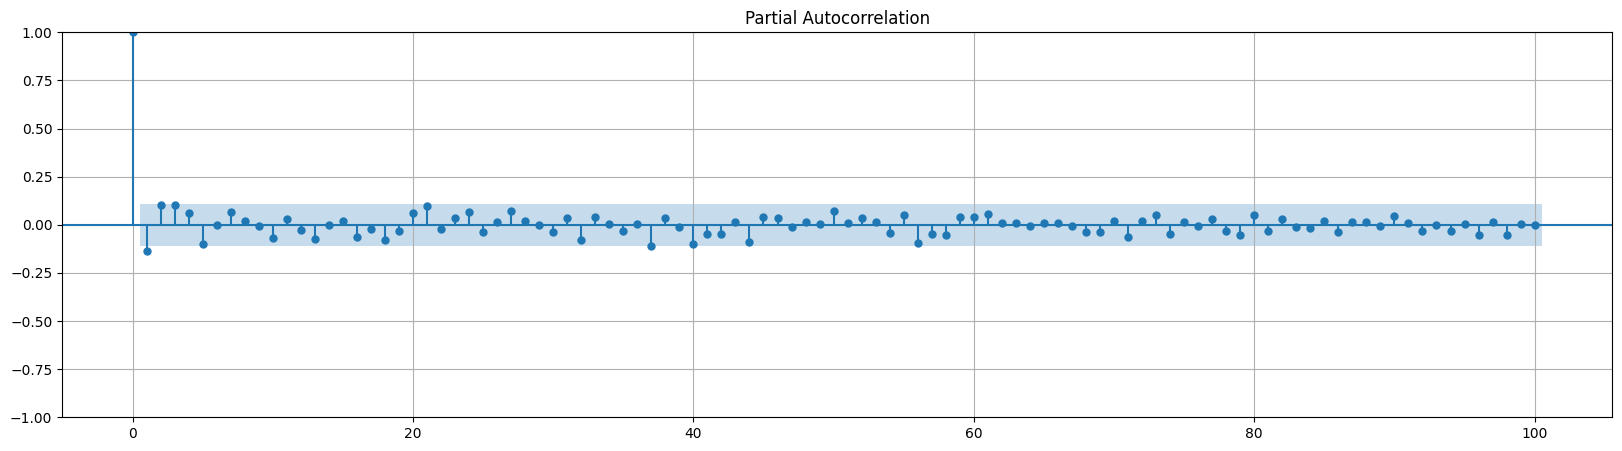

In [18]:
plt.figure(figsize=(20, 5))
sm.graphics.tsa.plot_acf(exp_change, lags=100, ax=plt.gca())
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 5))
sm.graphics.tsa.plot_pacf(exp_change, lags=100, ax=plt.gca())
plt.grid(True)
plt.show()

We observe that the relevant lag values are **different** than the previous ones

# Models

Let's continue working with the Brazil time series.

The EDA suggested to use as model a ARMA(1,1) or ARMA(3,2).

Let's try them both and see the difference in the results.



In [19]:
exp_data = change['Brazil']
exp_data = exp_data.asfreq('b')
exp_data = exp_data.fillna(method='ffill')

split the data in train and test

In [20]:
train_end = datetime(2020,12,31)

train_data = exp_data[:train_end]
test_data = exp_data[train_end + timedelta(days=1):]

Get the prediction timeframe (= test timeframe)

In [22]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

# ARMA(1,1)

Fit the model

In [23]:
model = ARIMA(train_data, order=(1,0,1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Change %   No. Observations:                  261
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -712.246
Date:                Thu, 14 Sep 2023   AIC                           1432.492
Time:                        15:09:14   BIC                           1446.750
Sample:                    01-02-2020   HQIC                          1438.223
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0407      0.226     -0.180      0.857      -0.483       0.402
ar.L1         -0.5541      0.161     -3.436      0.001      -0.870      -0.238
ma.L1          0.4256      0.174      2.442      0.0

As expected, the P value of both coefficients is lower than 0.5, so both are significat.

Compute the predictions

In [24]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

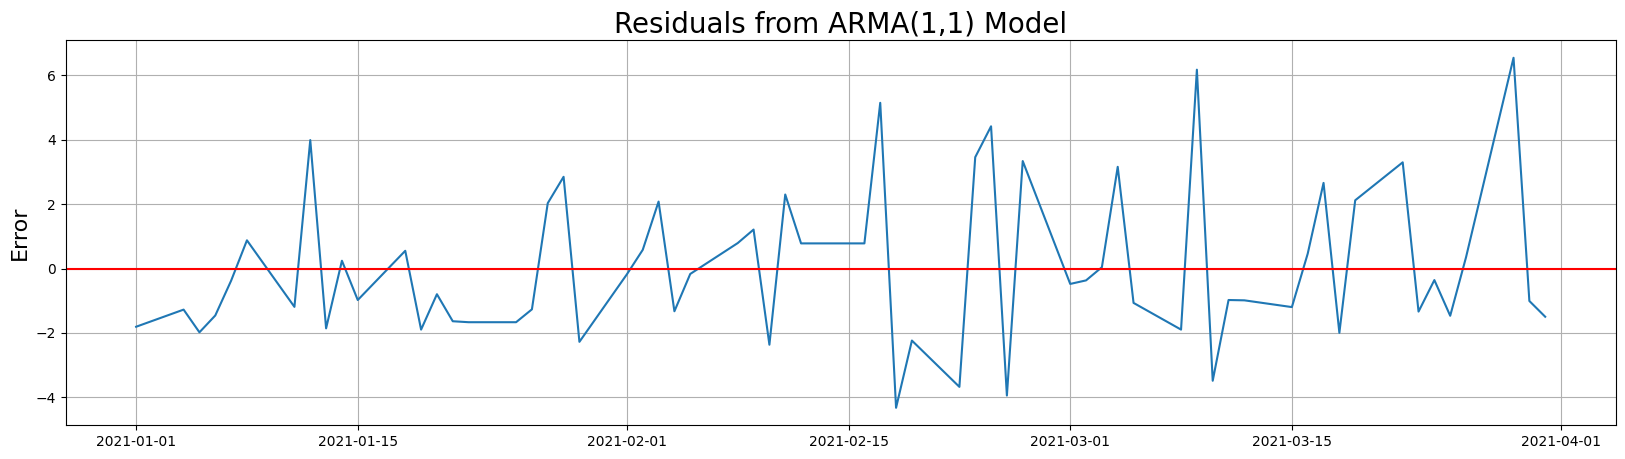

In [26]:
plt.figure(figsize=(20,5))
plt.plot(residuals)
plt.title('Residuals from ARMA(1,1) Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r')
plt.grid('on')
plt.show()

looking at the residuals, we are kinda close to the true value, but the error oscillates in time

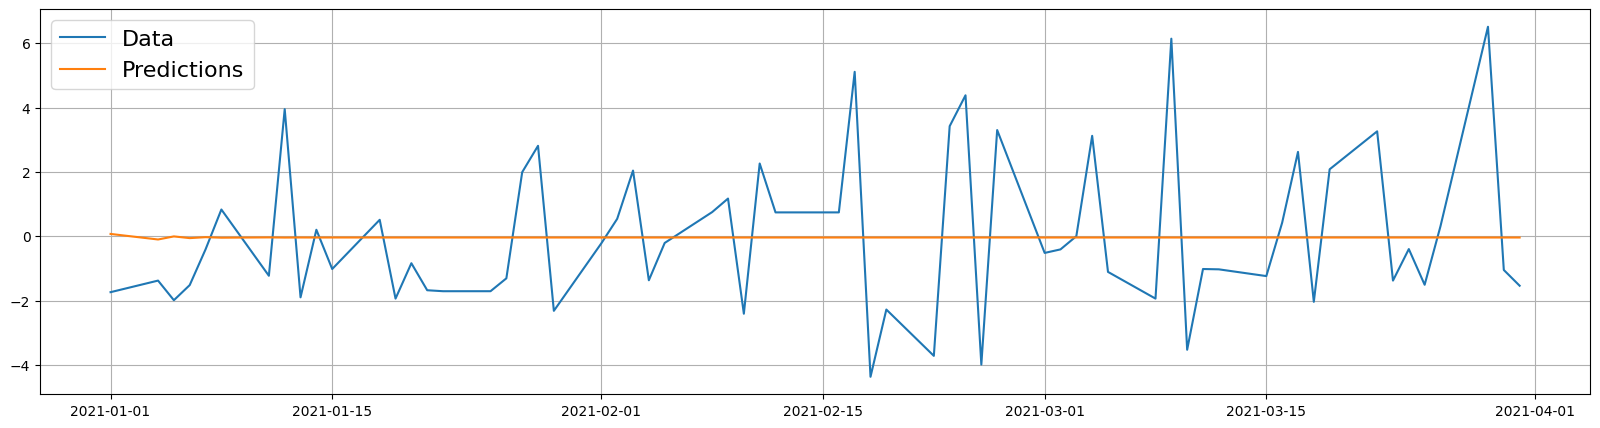

In [27]:
plt.figure(figsize=(20,5))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)
plt.grid('on')
plt.show()

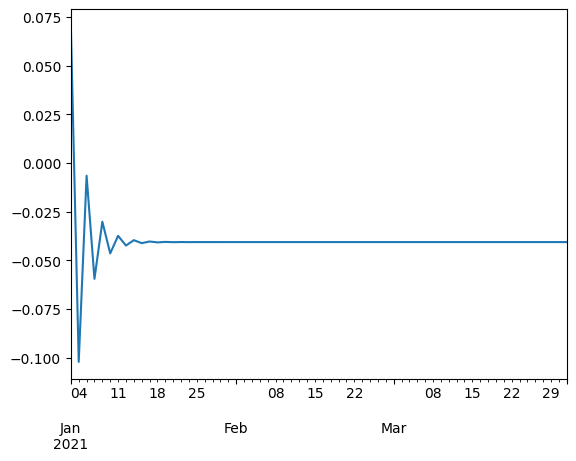

In [28]:
predictions.plot()
plt.show()

the predictions are settling (quite fast) to a constant value.

In [39]:
print('Mean Absolute Error:', round(np.mean(abs(residuals)), 4))
print('Root Mean Squared Error:', round(np.sqrt(np.mean(residuals**2)), 4))

Mean Absolute Error: 1.8689
Root Mean Squared Error: 2.355


The mean absolute error is relatively high: 1.86%

# ARMA(3,2) & ARMA(2,2)

Fit the model

In [43]:
model = ARIMA(train_data, order=(3,0,2))
model_fit = model.fit()

print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:               Change %   No. Observations:                  261
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -706.316
Date:                Thu, 14 Sep 2023   AIC                           1426.631
Time:                        15:16:53   BIC                           1451.583
Sample:                    01-02-2020   HQIC                          1436.661
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0448      0.252     -0.178      0.859      -0.538       0.448
ar.L1          0.1441      0.072      2.014      0.044       0.004       0.284
ar.L2         -0.6468      0.134     -4.824      0.0

We notice that the third lag in the AR part is not statistically relevant (P value above 0.5).
Hence, let's straight away reduce the model to an ARMA(2,2) model

In [44]:
model = ARIMA(train_data, order=(2,0,2))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Change %   No. Observations:                  261
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -706.324
Date:                Thu, 14 Sep 2023   AIC                           1424.648
Time:                        15:18:11   BIC                           1446.035
Sample:                    01-02-2020   HQIC                          1433.245
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0455      0.250     -0.182      0.856      -0.536       0.445
ar.L1          0.1429      0.069      2.070      0.038       0.008       0.278
ar.L2         -0.6560      0.088     -7.464      0.0

In [45]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

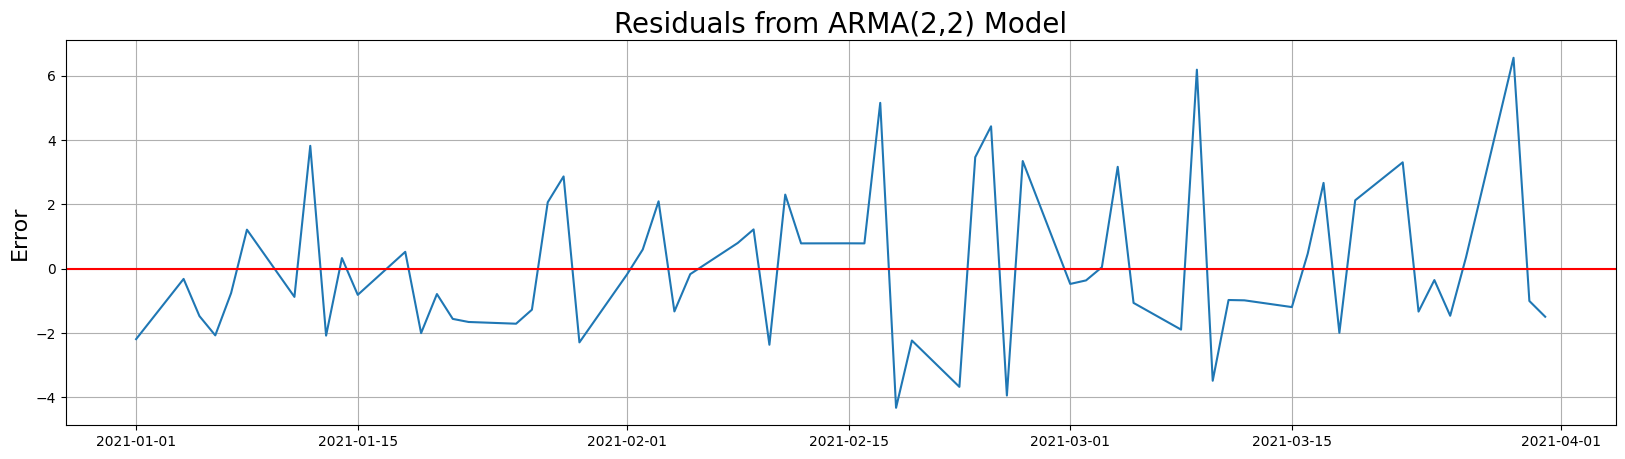

In [46]:
plt.figure(figsize=(20,5))
plt.plot(residuals)
plt.title('Residuals from ARMA(2,2) Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r')
plt.grid('on')
plt.show()

There is not a big difference between these residuals and the one obtained with the simpler model

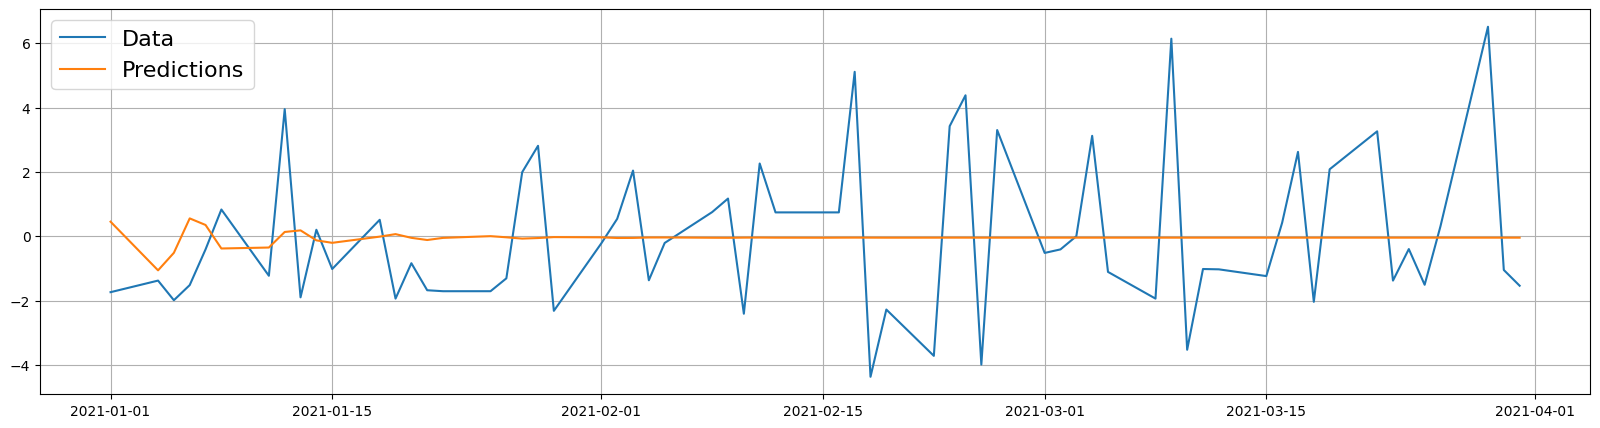

In [47]:
plt.figure(figsize=(20,5))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)
plt.grid('on')
plt.show()

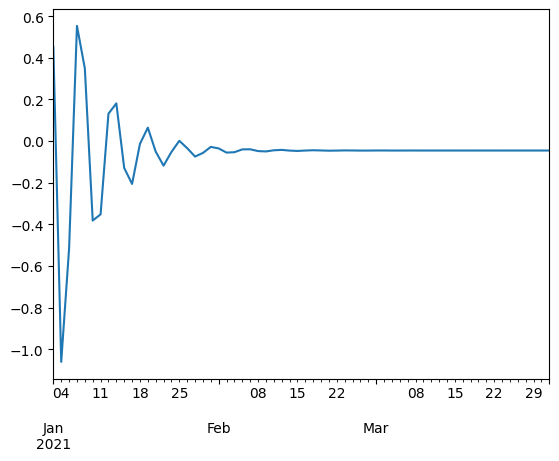

In [48]:
predictions.plot()
plt.show()

Actually, we noticed that at the beginning of the prediction horizon, the estimated values are closer to the real ones

In [49]:
print('Mean Absolute Error:', round(np.mean(abs(residuals)), 4))
print('Root Mean Squared Error:', round(np.sqrt(np.mean(residuals**2)), 4))

Mean Absolute Error: 1.8693
Root Mean Squared Error: 2.3578


The evaluation metrics, as expected, show the same performance level as the previous model

# Rolling Forecast Origin

We need to predict the stock prices on a **daily**, **weekly** and **monthly** basis.



In [50]:
# Define forecasting horizon (number of days to forecast)
forecast_horizon = 1

# Initialize an empty DataFrame to store forecast results
forecast_results = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])

# Perform rolling forecasts
for idx, end_date in enumerate(test_data.index[forecast_horizon-1:]):

  start_date = test_data.index[idx]

  # Select the training data up to the start_date
  curr_train_data = exp_data[:start_date - timedelta(days=1)]
  curr_test_data = exp_data[start_date : end_date]

  # train the model
  model = ARIMA(curr_train_data, order=(2,0,2))
  model_fit = model.fit()

  # make the predictions
  predictions = model_fit.predict(start=start_date, end=end_date)

  # Concat the results to the dataframe
  curr_results = pd.DataFrame({
      'Date': curr_test_data.index,
      'Actual': curr_test_data.values,
      'Forecast': np.round(predictions.values, 2)
  })
  forecast_results = pd.concat((forecast_results, curr_results), ignore_index=True)


In [51]:
import plotly.express as px

fig = px.line(forecast_results, x='Date', y=['Actual', 'Forecast'])
fig.show()

In [53]:
residuals = forecast_results['Actual'] - forecast_results['Forecast']

print('Mean Absolute Error:', round(np.mean(abs(residuals)), 4))
print('Root Mean Squared Error:', round(np.sqrt(np.mean(residuals**2)), 4))

Mean Absolute Error: 1.9331
Root Mean Squared Error: 2.4554


using a rolling origin approach we improve the quality of the predictions, but not that much.

The problem here is the **model**: we are not using the most appropriate one